# Introduction


In [2]:
# Append path for MyUtils libraries
import sys
sys.path.append('../..')

####################################################################################
# Data handling 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly.tools as tls

####################################################################################
# TA-Lib: 
import talib

####################################################################################
# Other utilities
import datetime
import time
import os
import sys
import math
from enum import Enum

Using TensorFlow backend.


In [3]:
# imports library with own utilities for data handling and machine learning models
import common.MyUtils as utils
print('Ready!')

Ready!


In [4]:
# Load instrument's data feed and visualize first rows
df = utils.load_hist('../csv_data/EURUSD_M15.csv', freq='15min', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2001-04-02 00:15:00,0.8744,0.8753,0.8732,0.8751,0.87475,0.874533,0.874500,0.0007,15,0,65.0,0.0,50.0
2001-04-02 00:30:00,0.8752,0.8757,0.8751,0.8753,0.87525,0.875367,0.875325,0.0002,30,0,44.0,0.0,50.0
2001-04-02 00:45:00,0.8753,0.8755,0.8742,0.8749,0.87510,0.874867,0.874975,-0.0004,45,0,67.0,0.0,50.0
2001-04-02 01:00:00,0.8749,0.8760,0.8748,0.8757,0.87530,0.875500,0.875350,0.0008,60,0,76.0,0.0,50.0
2001-04-02 01:15:00,0.8756,0.8760,0.8754,0.8756,0.87560,0.875667,0.875650,-0.0001,75,0,67.0,0.0,50.0


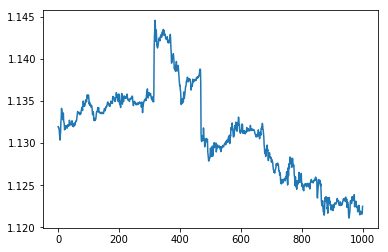

In [8]:
# Let's apply trend indentification on last 1000 samples
_df = df[-1000:].copy()
plt.subplot(1,1,1)
plt.plot(_df.CLOSE.values)


In [27]:
# ADX
_df['ADX'] = talib.ADX(_df.HIGH, _df.LOW, _df.CLOSE, timeperiod=14)

# ADX_SMA
sma_period = 20
_df['ADX_SMA_{}'.format(sma_period)] = talib.SMA(adx, timeperiod=sma_period)

ema_period = 20
_df['ADX_EMA_{}'.format(ema_period)] = talib.EMA(adx, timeperiod=ema_period)



In [28]:
# ADX 
_df0 = _df.reset_index(drop=True)
line_adx = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.ADX,     
    name='ADX', 
    line=scatter.Line(color='blue', width=1))
line_adx_sma = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0['ADX_SMA_{}'.format(sma_period)],     
    name='ADX_SMA_{}'.format(sma_period), 
    line=scatter.Line(color='red', width=1))
line_adx_ema = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0['ADX_EMA_{}'.format(ema_period)],     
    name='ADX_EMA_{}'.format(ema_period), 
    line=scatter.Line(color='green', width=1))

py.iplot([line_adx, line_adx_sma, line_adx_ema], filename='simple_ohlc')


In [7]:
# let's plot price and indicators

_df0 = _df.reset_index(drop=True)

# selects zigzag points
_dfz = _df0[_df0.ZIGZAG > 0]

#--------------- FIRST CHART ---------------

# Create Candlestick
trace = go.Ohlc(x=_df0.reset_index()['index'],
                open=_df0.OPEN,
                high=_df0.HIGH,
                low=_df0.LOW,
                close=_df0.CLOSE,
                name='eurusd_M15')


# Creates 3 lines for the BollingerBands indicator
line_bbup = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_HI,
    name= 'UpperBand',
    line=scatter.Line(color='brown', dash='dash')
    )
line_bbmid = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_MA,
    name= 'MiddleBand',
    line=scatter.Line(color='brown', dash='dash')
    )
line_bbdn = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_LO,
    name= 'LowerBand',
    line=scatter.Line(color='brown', dash='dash')
    )
# Creates zigzag lines 
line_zigzag = go.Scatter(
    x=_dfz.reset_index()['index'], 
    y=_dfz.ZIGZAG,     
    name='zigzag', 
    line=scatter.Line(color='black', width=1))


#--------------- SECOND CHART ---------------
# Bollinger Bands width 
line_bbwidth = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.BOLLINGER_WIDTH,     
    name='BB_WIDTH', 
    line=scatter.Line(color='blue', width=2))


#--------------- THIRD CHART ---------------
# Bollinger Bands %b 
line_bb_b = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.BOLLINGER_b,     
    name='BB_%b', 
    line=scatter.Line(color='red', width=2))


#--------------- FOURTH CHART ---------------
# MACD 
line_macd = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.MACD,     
    name='MACD', 
    line=scatter.Line(color='blue', width=2))
line_macdsig = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.MACD_SIG,     
    name='MACD_sig', 
    line=scatter.Line(color='red', width=2))


#--------------- FIRTH CHART ---------------
# ADX 
line_adx = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.ADX,     
    name='ADX', 
    line=scatter.Line(color='blue', width=2))



#--------------- BUILDER ---------------
fig = plotly.tools.make_subplots(rows=5, 
                                 cols=1, 
                                 subplot_titles=('Price&Zigzag', 'Bollinger Width', 'Bollinger %b', 'MACD', 'ADX'),
                                 shared_xaxes=True, 
                                 vertical_spacing=0.1)
fig.append_trace(trace, 1, 1)
fig.append_trace(line_zigzag, 1, 1)
fig.append_trace(line_bbwidth, 2, 1)
fig.append_trace(line_bb_b, 3, 1)
fig.append_trace(line_macd, 4, 1)
fig.append_trace(line_macdsig, 4, 1)
fig.append_trace(line_adx, 5, 1)
fig['layout'].update(height=800, title='Price & Indicators')
py.iplot(fig, filename='simple_ohlc')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]
[ (5,1) x1,y5 ]



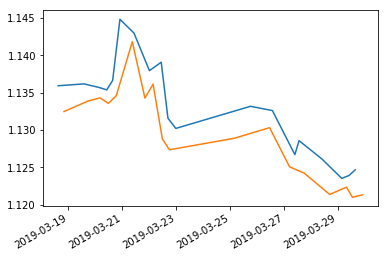

In [18]:
# let's analyze zigzags
zz_max = _df[(_df.ZIGZAG > 0) & (_df.ZIGZAG_ACTION=='high')]
zz_max.ZIGZAG.plot()

zz_min = _df[(_df.ZIGZAG > 0) & (_df.ZIGZAG_ACTION=='low')]
zz_min.ZIGZAG.plot()

In [72]:
# Let's extract some information

# count of continuous decreasing pairs
dec_p1 = dec_p2 = 0
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x] <= zigzag_y[x-2]:
    dec_p1 +=1
  else:
    break
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x-1] <= zigzag_y[x-3]:
    dec_p2 +=1
  else: 
    break
print('decp1={}, decp2={}'.format(dec_p1, dec_p2))


decp1=0, decp2=1


In [73]:
# count of continuous increasing pairs
inc_p1 = inc_p2 = 0
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x] >= zigzag_y[x-2]:
    inc_p1 +=1
  else:
    break
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x-1] >= zigzag_y[x-3]:
    inc_p2 +=1
  else: 
    break
print('incp1={}, incp2={}'.format(inc_p1, inc_p2))


incp1=1, incp2=0


In [68]:
maxs      

[0.8991, 0.8977, 0.9052, 0.9079, 0.9093, 0.8987, 0.9021, 0.9051]

In [67]:
# builds decreasing max
dec_max = []
for x in range(len(maxs)-1):  
  if x==0 and x >= max(maxs[x:]):
    dec_max.append(mins[x])
  elif x>0 and x >= max(maxs[x:]) and x <= min(maxs[:x]):
    dec_max.append(maxs[x])
      
dec_max                   

[]



As said, this model will predict an estimation of High and Low prices for next session. To achieve it, it will predict the price movement from the current close price. So, knowing the current close time and the prediction movement, it will extract the real High,Low prices.

So, both outputs could be expressed with these equations:

PREDICTION_HIGH(t+1) = PRICE_HIGH(t+1) - CLOSE(t)

PREDICTION_LOW(t+1) = PRICE_LOW(t+1) - CLOSE(t)


In [ ]:
# function to generate predictions as explained above
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Add both outputs to df dataframe and check first rows (also remove NaNs)
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

In [ ]:
# Visualization of all columns: input features and target predictions
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Data preprocessing

This model will predict price movement one timestep ahead, from a loopback window of the last 4 timesteps: 

(t-3), (t-2), (t-1), (t) ==> (t+1)

LSTM cells require input features and target outputs to be in a proper format:

- Input features shape: (num_samples, num_loopback_timesteps, num_input_features)
- Output target shape: (num_outputs * num_prediction_timesteps)

To adapt data contained in df dataframe into these sets, I use function 'series_to_supervised' contained in python file 'MyUtils.py'. You can check how it works there.


In [ ]:
# Setup:

# Num outputs to predict
num_outputs = 2

# Num input features
num_inputs = len(df.columns) - num_outputs

# Num loopback timesteps
n_in = 4

# Num timesteps to predict
n_out = 1

# Flag to remove NaN values from  df dataframe
dropnan = True

# Run the preprocessor and get a new dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)

# Check the result
print(df_nn.shape)
df_nn.head()

In [ ]:
# DATA DEBUGGING:
# Now I use an auxiliar temporal dataframe '_df' to check if target outputs are calculated correctly. I check if 'next_high' 
# column has the same content as 'HIGH(t)' shifted 1 timestemp in the future.
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

### Data normalization

A general preprocessing operation in Neural Networks is data normalization, in this case, as LSTM cells contains a 'tanh' cell, I will normalize all features in range [-1,+1].

I will save the scaler for further use when de-normalization process is required later on model validation. I use 'MinMaxScaler' from Scikit-learn library. For this purpose I use 'normalize_data' function from MyUtils.py file:

In [ ]:
#### Data normalization. Get the scaler (save a copy on disk for later use) and a new normalized dataframe: dfnorm
dfnorm, scaler = utils.normalize_data(df_nn, feat_range = (-1,1), csv_to_save=None, scaler_to_save='../scaler_data/scaler.data')
# check result
dfnorm.describe()

## 3 RNN model construction

First of all, I like to say that I will use Keras as fronted over Tensorflow, to build a stacked LSTM network.

I use function 'build_lstm_net' in MyUtils.py file (check it there if curious). It requires different arguments: num_inputs, num_outputs, loopback and predicted timestemps, number of LSTM layers, ...

In first place  I will execute a cross validation phase, using 'Kfolds' from Scikit-learn to get a first impression about the model. I'll generate 5 different models.


### Cross validation

dfnorm dataframe is used to get train-test in-out pairs. LSTM model is:

- 3 stacked LSTM layers with 64 neurons each.
- 1 Dense hidden layer with 128 neurons.
- 1 Dense output layer with 2 neurons (one per output)
- Dropout after each layer to improve generalization and avoid overfitting


In [ ]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_0412_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

As this model seems to be raise good results, I will train with a whole train-test dataset.

### Model training

In this case, I will use 'dfnorm' dataframe and get 80% (around 88000 samples) for training and 20% (around 22000 samples) for validation. I'll use 'prepare_training_data' and 'fit' functions from MyUtils.py file:

In [ ]:
# Prepare data for train-test
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


In [ ]:
# Build the RNN model with same configuration
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weightsH4_3.2.64.128.hd5')

In [ ]:
# Setup:

# Training epochs
num_epochs = 30
# Batch size
batchsize = 32
# Ratio validation-training (20%)
val_ratio = 0.2
# Enable data shuffling
shuffle = True
# Enable result plotting
plot_results = True
# Start training
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results, verbose=2)

In [ ]:
# Save model weights on disk, as HDF5 file
model.save_weights('../hd5_data/weightsH4_3.2.64.128.hd5')

### Model verification

Once trained, let's check its behaviour with new data. Function 'test_rmse' in MyUtils.py executes the test and returns the RMSE result. A callback 'out_builder' is needed to de-normalize data to calculate RMSE.

In [ ]:
# column selection for 'out_builder' callback
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
# Callback to build de-normalized output data from normalized predictions
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
# Executes test process and visualizes RMSE result
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [ ]:
# Dataframe update:

# Reshape results into np.arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# Build a new dataframe named 'df_predict' with prediction results.
df_predict = df_nn[x_train.shape[0]:].copy()
#... add predictions...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... add targets...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... add some data-debugging columns to validate results
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... add RMSE error
df_predict['RMSE'] = armse[:]

# Visualize first rows for visual debugging
df_predict.head()

Now I carry on a visual inspection of results obtained. I can range the visualization plot to zoom in or out.

Target range (real range between high and low prices) is coloured in grey, while predicted range (area between predicted high and low) is coloured in yellow.

In [ ]:
plt.figure(figsize=(16,16))
i=-10
x = np.arange(10)
y1 = df_predict['TARGET_HIGH'].values[i:]
y2 = df_predict['TARGET_LOW'].values[i:]
y3 = df_predict['PREDICT_HIGH'].values[i:]
y4 = df_predict['PREDICT_LOW'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


As can be seen, there exist a small prediction error. In general, predicted range between High and Low prices as greater than real High-Low range.


### Next steps

Once verified that prediction is valid for my purposes, it's time to build a dataframe for the next stage: A3C-LSTM agent.

In this new stage, the agent will require real time market data (bars, quotes, account info and predictions) to start its training process as a RL problem.

Now we are going to build a dataframe (only with bars, targets, predictions) for this next stage:

In [ ]:
# split historic data into input (X) and output (Y) variables and executes predictions
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
predictions = model.predict(X.reshape(X.shape[0], n_in, num_inputs), batch_size=1)

In [ ]:
# let's copy dfnorm and add predictions as new columns
df_predict = dfnorm.copy()
df_predict['OUT_HIGH(t+1)'] = predictions[:,0]
df_predict['OUT_LOW(t+1)']  = predictions[:,1]
df_predict.tail()

In [ ]:
# de-normalize data
df_predict = utils.denormalize_data(df_predict, scaler)
df_predict.tail()

In [ ]:
# Add new columns for expected targets
df_predict['TARGET_HIGH'] = df_nn['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_nn['OUT_LOW(t+1)'] 

#... calculate RMSE error between targets and predictions
df_predict['RMSE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH'], row['TARGET_LOW']]), np.asarray([row['OUT_HIGH(t+1)'], row['OUT_LOW(t+1)']]), multioutput = 'uniform_average')), axis=1)

# add new columns to get targets and predictions as absolute price values
df_predict['PREDICT_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)']
df_predict['PREDICT_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)']
df_predict['TARGET_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_HIGH']
df_predict['TARGET_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_LOW']

#... and calculate RMSE error using absolute price values
df_predict['RMSE_PRICE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH_PRICE'], row['TARGET_LOW_PRICE']]), np.asarray([row['PREDICT_HIGH_PRICE'], row['PREDICT_LOW_PRICE']]), multioutput = 'uniform_average')), axis=1)

df_predict.head()

In [ ]:
# Select only required columns for next stage
df_predict = df_predict[['OPEN(t)','HIGH(t)','LOW(t)','CLOSE(t)','OUT_HIGH(t+1)','OUT_LOW(t+1)','TARGET_HIGH','TARGET_LOW','RMSE','PREDICT_HIGH_PRICE','PREDICT_LOW_PRICE','TARGET_HIGH_PRICE','TARGET_LOW_PRICE', 'RMSE_PRICE']]
df_predict.tail()                      

In [ ]:
# Show targets (grey area) vs predictions (yellow area)
plt.figure(figsize=(16,16))
# Zoom in range to plot (can be changed)
i=-20
x = np.arange(-i)
y1 = df_predict['TARGET_HIGH_PRICE'].values[i:]
y2 = df_predict['TARGET_LOW_PRICE'].values[i:]
y3 = df_predict['PREDICT_HIGH_PRICE'].values[i:]
y4 = df_predict['PREDICT_LOW_PRICE'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])

In [ ]:
# Show RMSE errors
plt.subplot(1,2,1)
plt.plot(df_predict['RMSE'], color='b')
plt.legend(['RMSE_prediction'])
plt.subplot(1,2,2)
plt.plot(df_predict['RMSE_PRICE'], color = 'r')
plt.legend(['RMSE_price'])

In [ ]:
# Save file on disk
df_predict.to_csv('../csv_data/EURUSD_H4_predictions.csv', sep=';')
print('File saved!')